In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import glob
import xarray as xr
import xbudget
import regionate
import datetime
import cftime

import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import matplotlib as mpl

dpi = 100
mpl.rcParams['figure.dpi'] = dpi
sns.set_context("notebook")

import pandas as pd
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *

### Load in data

In [4]:
savedir = "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/data/model/"

In [5]:
def approximate_z(ds, dim = "zl"):
    tmp = ds.thkcello.cumsum(dim = dim)
    #average between 0 and cell bottom
    tmp1 = tmp.isel({dim: 0}) / 2 
    #get top of cell
    tmp2 = tmp.isel({dim : slice(0, -1)}) 
    #get bottom of cell
    tmp3 = tmp.isel({dim : slice(1, None)}) 
    #make sure cell interfaces are on same coordinate
    tmp2.coords[dim] = tmp3.coords[dim]
    #take average
    tmp4 = (tmp2 + tmp3) / 2

    ds["z"] = xr.concat([1. * tmp1, 1. * tmp4], dim = dim)    
    ds["z_bottom"] = 1. * tmp

    ds["z"] = ds["z"].where(ds["thkcello"] > 0) 
    ds["z_bottom"] = ds["z_bottom"].where(ds["thkcello"] > 0) 

    return ds

In [6]:
sigma = 37.00
toSv = 1/1035*1e-6
toTg = 1e-9 

mass_flux_units = "Tg/s"
mass_flux_units_conversion = toTg

expt_colors = dict(); expt_colors["control"] = "#2f74b3"; expt_colors["forced"] = "#cc415a"

In [7]:
#float_conversion default is years to seconds

def integrate(ds, varname = "surface_boundary_fluxes", dim = "time", float_conversion = 3.154e+7): 
    
    # Check if time is datetime; if so, convert dt to seconds
    
    if np.issubdtype(ds[dim].dtype, np.datetime64):
        dt = da[dim].diff(dim) / np.timedelta64(1, "s")  # Convert to seconds
    elif np.issubdtype(ds[dim].dtype, "O"): 
        
        dt = ds[dim].diff(dim) / np.timedelta64(1, "s")  # Convert to seconds
    
    elif np.issubdtype((1. * ds[dim]).dtype, np.float64):
        dt = float_conversion * ds[dim].diff(dim)  # Already in numeric format (assume seconds)
    
    dt_arr = xr.zeros_like(ds[dim]) * np.nan

    dt_arr.isel({dim : slice(1, None)}).values[:] = dt.values[:]
    dt_arr = dt_arr.astype("float")

    
    trapz = (ds.shift({dim: 1})[varname] + ds[varname]) * dt_arr / 2.0
    trapz = trapz.where(~np.isnan(trapz), 0) #replace nans with zeros 

    integral_ds = xr.zeros_like(trapz).rename(f"integrated_{varname}")
    integral_ds.values = trapz.cumsum(dim).values

    return integral_ds

In [9]:
ds = xr.open_dataset(
        datadir("/model/Southern_Ocean_WMT_Budget.nc"))
ds["surface_boundary_fluxes"] = ds["boundary_fluxes"] - ds["bottom_flux_heat"]
ds = ds.sel(sigma2_l_target = sigma, method = "nearest")

ds_integrated = integrate(ds, "surface_boundary_fluxes")

yearly_average = lambda ds: ds.groupby("time.year").mean("time")
ds_columns_forced = xr.open_dataset(
        datadir("/model/Tracer_Columns_Bottom250_forced.nc"))

ds_columns_control = xr.open_dataset(
        datadir("/model/Tracer_Columns_Bottom250_control.nc"))
ds_columns_control.coords['time'] = ds_columns_forced.time.values

ds_columns = xr.concat([
    yearly_average(ds_columns_forced).expand_dims(exp=['forced']),
    yearly_average(ds_columns_control).expand_dims(exp=['control'])
], dim='exp')




In [82]:
cfc11_arrival = xr.where(ds_columns.cfc11 >= 0.01, 1, 0)
cfc11_arrival = cfc11_arrival * 1. * cfc11_arrival.year
cfc11_arrival = cfc11_arrival.where(cfc11_arrival > 0)
cfc11_arrival = cfc11_arrival.min(dim = "year", skipna = True)

arrival_diff = -cfc11_arrival.diff("exp").isel(exp = 0).drop_vars("exp").expand_dims(exp=['difference'])

# cfc11_arrival = xr.concat([cfc11_arrival, arrival_diff], dim= "exp")

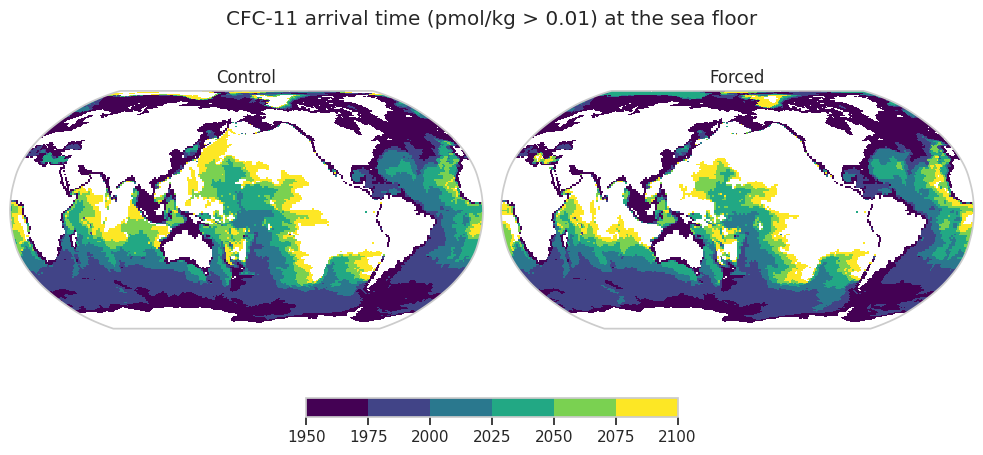

In [90]:
import matplotlib.patches as  mpath
from matplotlib.colors import BoundaryNorm, ListedColormap
import cartopy.feature as cfeature

fig, ax = plt.subplots(1, 2, figsize = (10, 5),
                        subplot_kw={'projection':ccrs.Robinson(central_longitude = 180)})

arrival_levels = np.arange(1950, 2100.1, 25)  
arrival_levels[np.abs(arrival_levels) < 1e-16]  = 0
cmap = plt.get_cmap("viridis")
norm = BoundaryNorm(arrival_levels, ncolors=cmap.N, clip=False)


ax[0].pcolormesh(cfc11_arrival.geolon, cfc11_arrival.geolat, 
                 cfc11_arrival.sel(exp = "control"), 
                 transform = ccrs.PlateCarree(), 
                 cmap = cmap, norm = norm)
ax[0].set_title("Control")

cb = ax[1].pcolormesh(cfc11_arrival.geolon, cfc11_arrival.geolat, 
                 cfc11_arrival.sel(exp = "forced"), 
                 transform = ccrs.PlateCarree(), 
                 cmap = cmap, norm = norm)
ax[1].set_title("Forced")

fig.tight_layout()
fig.suptitle("CFC-11 arrival time (pmol/kg > 0.01) at the sea floor", y = 0.85)
fig.colorbar(cb, ax = ax[:2], orientation = "horizontal", fraction = 0.04)


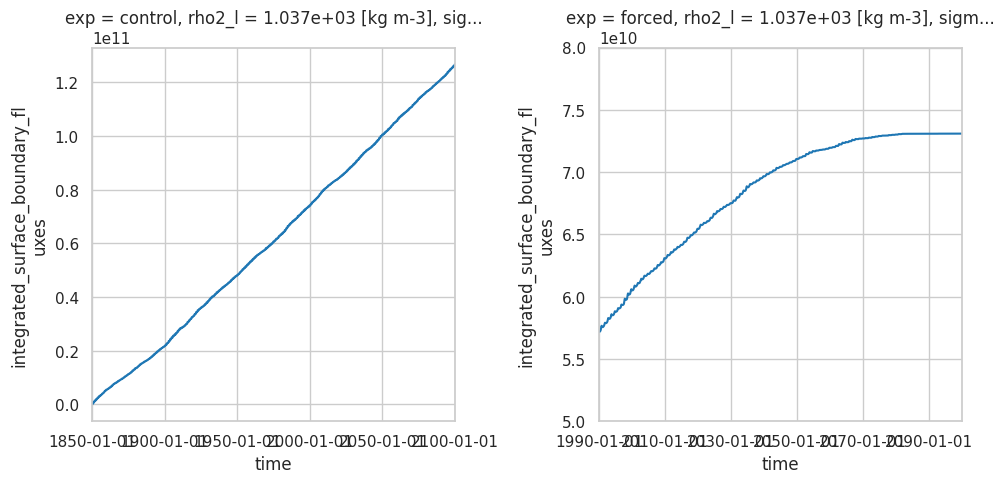

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

expt = 1
(ds_integrated * 1e-9).isel(exp = expt).plot(ax = ax[0])

start = cftime.DatetimeNoLeap(1850, 1, 1)
end = cftime.DatetimeNoLeap(2100, 1, 1)
xticks = [cftime.DatetimeNoLeap(num, 1, 1) for num in np.arange(1850, 2101, 50)]

ax[0].set_xlim(start, end);
ax[0].set_xticks(xticks);

(ds_integrated * 1e-9).isel(exp = 0).plot(ax = ax[1])

start = cftime.DatetimeNoLeap(1990, 1, 1)
end = cftime.DatetimeNoLeap(2100, 1, 1)
xticks = [cftime.DatetimeNoLeap(num, 1, 1) for num in np.arange(1990, 2101, 20)]

ax[1].set_xlim(start, end);
ax[1].set_xticks(xticks);
ax[1].set_ylim(5e10, 8e10)

fig.tight_layout()

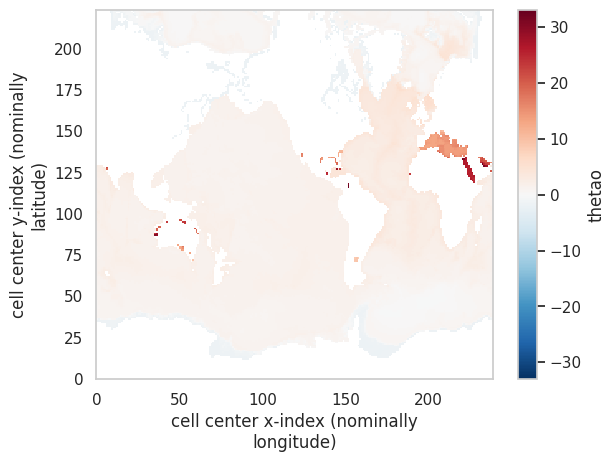

In [90]:
dim = "time"
ds_integrated_sub = ds_integrated.sel(time = slice("1990", None)).sel(exp = "forced")
ds_integrated_sub = (ds_integrated_sub - ds_integrated_sub.mean("time")) / ds_integrated_sub.std("time")

ds_columns_forced_sub = ds_columns_forced.sel(time = slice("1990", None))
ds_columns_forced_sub["thetao"].mean("time").plot()
ds_columns_forced_sub = (ds_columns_forced_sub - ds_columns_forced_sub.mean("time")) / ds_columns_forced_sub.std("time")
ds_columns_forced_sub = ds_columns_forced_sub.where(ds_columns_forced_sub.geolat < -40)
ds_columns_forced_sub["areacello"] = ds_columns_forced_sub.areacello.where(ds_columns_forced_sub.geolat < -40)

# ds_columns_forced_sub = ds_columns_forced_sub.where((ds_columns_forced["geolat"] < -40) * (ds_columns_forced["geolat"]  > -60))

In [69]:
def area_average(ds, var): 
    return (ds[var] * ds_columns_forced_sub["areacello"]).sum(["xh", "yh"]) / ds_columns_forced_sub["areacello"].sum(["xh", "yh"])

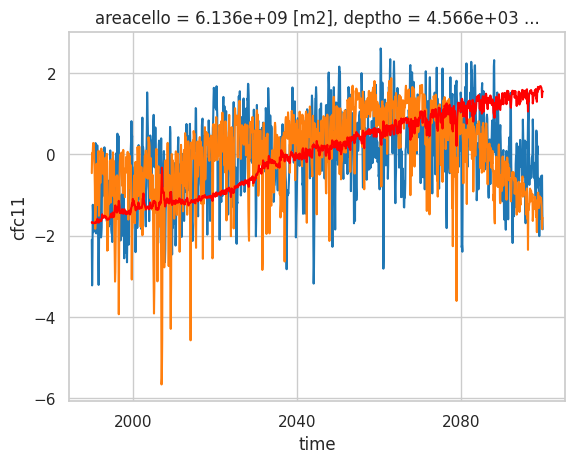

In [103]:
ds_columns_forced_sub.sel(xh = 150, yh = 50, method = "nearest").thetao.plot()
ds_columns_forced_sub.sel(xh = 150, yh = 50, method = "nearest").so.plot()
(ds_columns_forced_sub.sel(xh = 150, yh = 50, method = "nearest").cfc11).plot(c = "red")

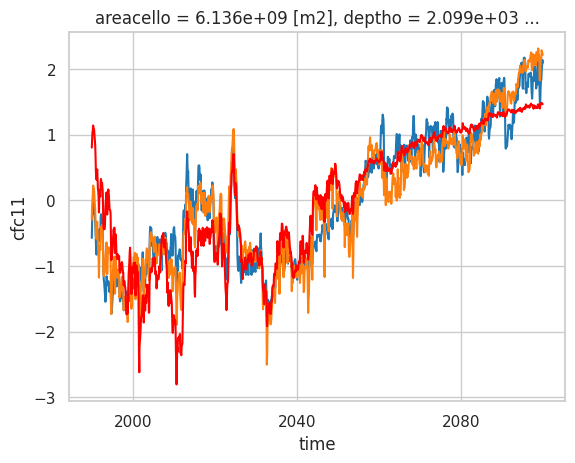

In [105]:
ds_columns_forced_sub.sel(xh = 170, yh = 50, method = "nearest").thetao.plot()
ds_columns_forced_sub.sel(xh = 170, yh = 50, method = "nearest").so.plot()
(-ds_columns_forced_sub.sel(xh = 170, yh = 50, method = "nearest").cfc11).plot(c = "red")


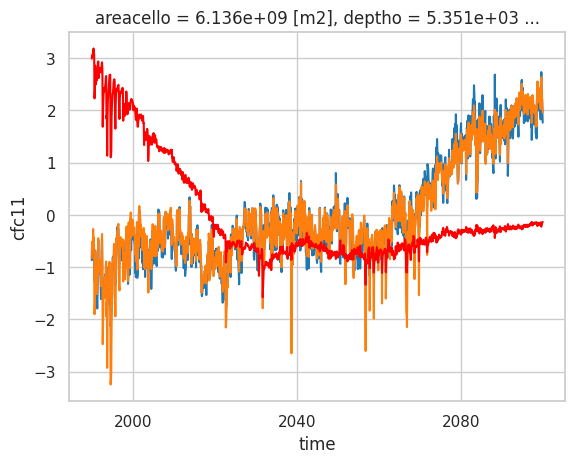

In [109]:
ds_columns_forced_sub.sel(xh = 220, yh = 50, method = "nearest").thetao.plot()
ds_columns_forced_sub.sel(xh = 220, yh = 50, method = "nearest").so.plot()
(ds_columns_forced_sub.sel(xh = 220, yh = 50, method = "nearest").cfc11).plot(c = "red")


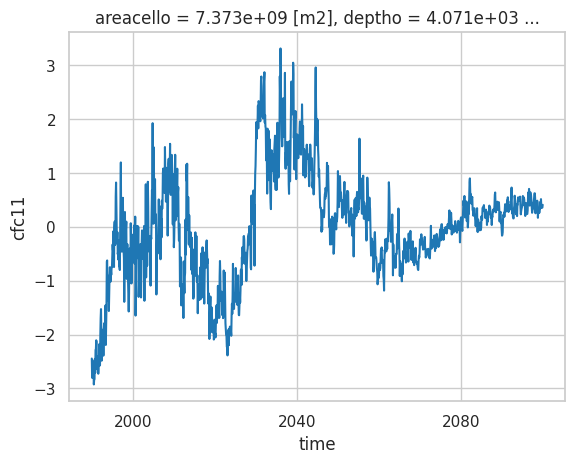

In [36]:
from dtw import *

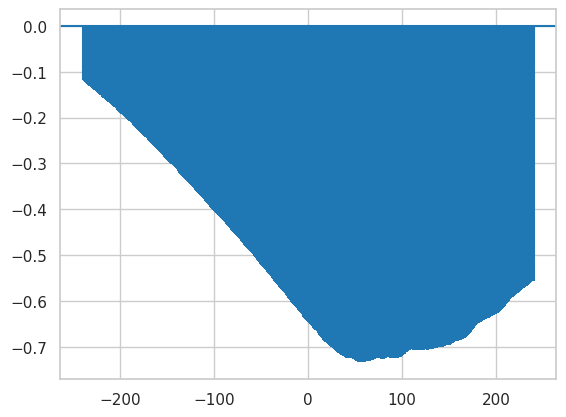

In [73]:
values = plt.xcorr(test_ts, ds_integrated_sub, maxlags = 12 * 20); 
lags, corrvals = values[0], values[1]

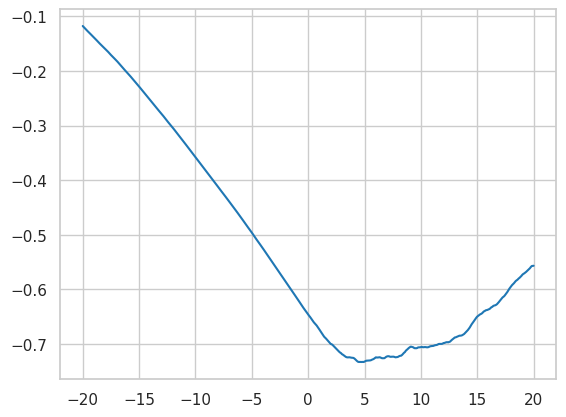

In [74]:
plt.plot(lags / 12, corrvals)